# Diamond EP Grouping by Resolution Limit

Previously the data was grouped by spacegroups, and different clusters of high to null success rates were found. Each spacegroup yielded different predictive performance, which was better for higher success rate clusters.

However, the data remains largely overlapped/unclear. Hopefully, grouping it by different resolution limits will result in an improvement.

In [1]:
import sys
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

Dials


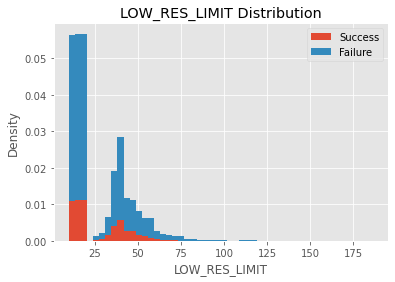

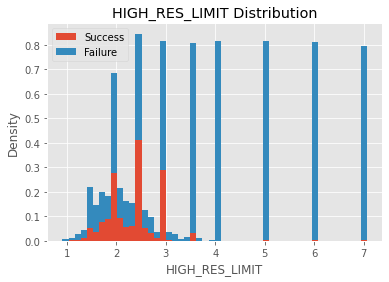

------------------------------------------------------------
3Dii


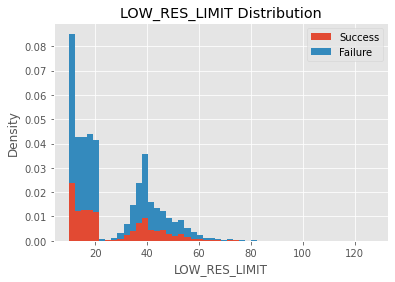

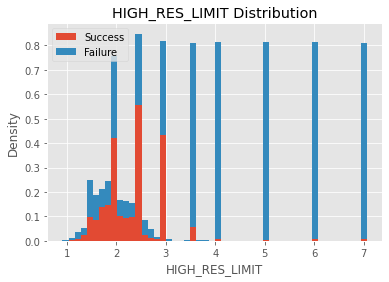

------------------------------------------------------------


In [2]:
for k, v in data.items():
    print(k.title())
    x, y = v.unpack()
    
    # separate success/failure
    mask_win, mask_lose = y == 1, y == 0
    x_win, x_lose = x[mask_win], x[mask_lose]

    # show resolutions distribution
    for col_name in ["LOW_RES_LIMIT", "HIGH_RES_LIMIT"]:
        # create stacked histograms
        fig, ax = plt.subplots()
        ax.hist([x_win[col_name], x_lose[col_name]], bins=50, stacked=True,
                density=True, label=["Success", "Failure"])

        # Aesthetics
        ax.set_xlabel(col_name)
        ax.set_ylabel("Density")
        ax.set_title(f"{col_name} Distribution")
        ax.legend()

        plt.show()
    
    print("-"*60)

- **Low Resolution Limit**: Largely distributed on the <25 area (equal on this area). Seemingly normal distribution focused on ~40.
- **High Resolution Limit**: Multiple discrete values (2, 2.5, 3, 3.5, 4, 5, 6 and 7). Smaller seemingly normal distribution around 2. Success mainly for <= 3 (fail otherwise).

From this, it is intuitive to discretize the data based on the **high resolution limit**, which already seems fairly discretized.

Dials


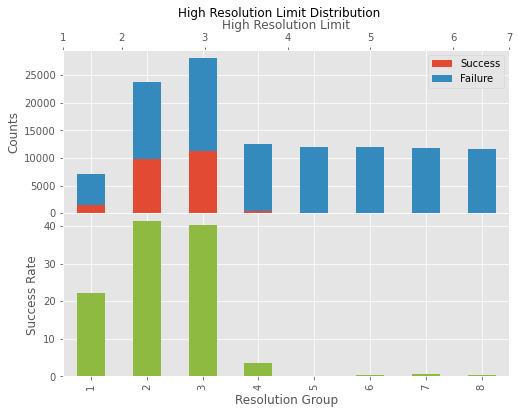

------------------------------------------------------------
3Dii


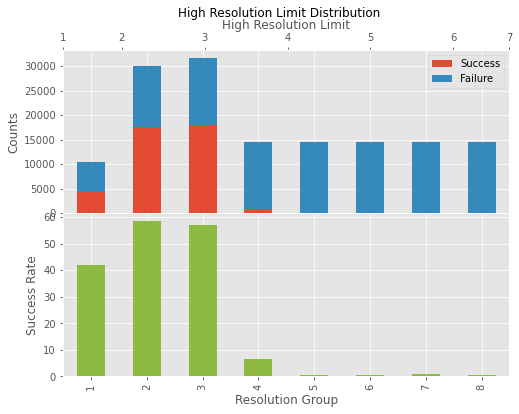

------------------------------------------------------------


In [3]:
from sklearn.preprocessing import KBinsDiscretizer


for k, v in data.items():
    print(k.title())
    x, y = v.unpack()

    # discretize high resolution limit
    n_bins = 8  # identify n discrete high resolutions
    disc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy="uniform")
    cats_high_res = disc.fit_transform(x[["HIGH_RES_LIMIT"]]).flatten().astype(int)

    # prepare figure
    fig, (ax_up, ax_down) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    fig.subplots_adjust(hspace=0)

    # show discretized distribution
    bar_width = .5
    groups = y.groupby(cats_high_res)
    groups.sum().plot.bar(ax=ax_up, label="Success", color="C0")
    (groups.count() - groups.sum()).plot.bar(ax=ax_up, bottom=groups.sum(), label="Failure", color="C1")

    # show success rate
    winrate = groups.sum() / groups.count()
    (winrate * 100).plot.bar(ax=ax_down, color="C5")  # percentage success rate

    # aesthetics
    ax_up.set_ylabel("Counts")
    ax_up.legend()
    ax_down.set_ylabel("Success Rate")
    ax_down.set_xlabel("Resolution Group")
    ax_down.set_xticklabels(ax_down.get_xticks() + 1)
    fig.suptitle("High Resolution Limit Distribution")

    # add secondary axis
    bin_edges = disc.bin_edges_[0]
    bin_centres = bin_edges[:-1] + np.diff(bin_edges) / 2
    unique_cats = np.unique(cats_high_res)
    secaxis = ax_up.secondary_xaxis("top",
                functions=(lambda a: np.interp(a, unique_cats, bin_centres),
                           lambda a: np.interp(a, bin_centres, unique_cats)))
    secaxis.set_xlabel("High Resolution Limit")
    
    
    plt.show()
    print("-" * 60)

- **Maximum success rate for roughly 2-3.5 $\unicode[serif]{xC5}$** (groups 2/3)
- Pratically **no success for $\geq4 \unicode[serif]{xC5}$**, for any database
- **DIALS never has positive success rate**, while XDS roughly doubles this, achieving positive success rate for the optimal range mentioned above
- Overall, **XDS significantly more successful than DIALS**

Now analyse more clearly the contents of each group.

In [4]:
from grouping import GroupedData


for db_kind, datum in data.items():
    print(db_kind.title())
    x, y = datum.unpack()
    
    # discretise into bins
    n_bins = 8
    disc = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="uniform")
    cats_high = disc.fit_transform(x[["HIGH_RES_LIMIT"]]).flatten().astype(int) + 1
    
    # get names describing resolution of each category
    bin_edges = disc.bin_edges_[0]
    names_res = [f"{round(bin_edges[i], 2)}-{round(bin_edges[i+1], 2)}"
                 for i in range(len(bin_edges)-1)]
    
    # group data
    groups = GroupedData(x, y)
    groups.group(cats_high)
    groups.sort(np.unique(cats_high), inplace=True)

    # show every correlation
    for i, group in groups:
        print(f"{'-'*30}\n"
              f"{i}: {names_res[i-1]}")
        x, y = group.unpack()
        corr = x.corrwith(y).sort_values(ascending=False, key=lambda a: abs(a))
        print(corr.head())

    print("-"*60)

Dials
------------------------------
1: 0.91-1.68
ANOMALOUS_CORRELATION     0.352176
DIFF_I                    0.316709
SHELXC_CFOM               0.297985
ANOMALOUS_SLOPE           0.257502
ANOMALOUS_COMPLETENESS    0.243160
dtype: float64
------------------------------
2: 1.68-2.45
SHELXC_CFOM              0.457891
ANOMALOUS_CORRELATION    0.430085
DIFF_I                   0.390159
ANOMALOUS_SLOPE          0.312431
SHELXC_SIGNAL            0.223072
dtype: float64
------------------------------
3: 2.45-3.22
SHELXC_CFOM              0.590798
ANOMALOUS_CORRELATION    0.460545
DIFF_I                   0.377198
ANOMALOUS_SLOPE          0.333278
SHELXC_SIGNAL            0.242053
dtype: float64
------------------------------
4: 3.22-3.98
SHELXC_CFOM              0.195319
ANOMALOUS_CORRELATION    0.133728
DIFF_I                   0.118521
ANOMALOUS_SLOPE          0.116064
SOLVENT_CONTENT          0.094798
dtype: float64
------------------------------
5: 3.98-4.75
DATASET_id        -0.040532
D

Dials:
- 4 main **highly-correlated** features: **SHELXC CFOM**, **anomalous correlation**, **DIFF I** and **anomalous slope**, in this order. The first is one of the latest steps in the pipeline, and as such the others are better indicators of initial success percentage.

XDS:
- For optimal resolution: **SHELXC CFOM** and **anomalous correlation**
- Also pay attention to **(anomalous) multiplicity/completeness** and **total molecular weight**
- Group 3: **RPIM/RMEAS/RMERGE DIFF I** with high correlation

Both:
- **Correlations are lower and seem more random for lower resolution groups,** as expected, since the data is practically unable to be mapped due to the low resolution, independent of other features

Use custom class to group by high resolution limit. Use shallow decision tree on data to see initial predictions and feature relevance.

In [3]:
from grouping import GroupedHighResolution
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


for db_kind, db in data.items():
    print(db_kind.title())
    X, y = db.unpack(drop_col=["SPACEGROUP", "DATASET_id"])
    
    # train decision tree on all data
    tree = DecisionTreeClassifier()
    tree.fit(X, y)
    
    # show top features and tree depth
    topfeat = pd.Series(tree.feature_importances_, index=X.columns)
    topfeat_pretty = topfeat[topfeat > 0].sort_values(ascending=False)
    print(topfeat_pretty)
    print("Depth:", tree.get_depth())
    
    # show tree structure
    print(export_text(tree, max_depth=3, feature_names=X.columns.tolist()))
    #plt.figure(figsize=(12, 8))
    #plot_tree(tree, max_depth=3, feature_names=X.columns.tolist(), fontsize=5)
    #plt.show()
    
    print("-"*60)

Dials
HIGH_RES_LIMIT               0.272754
SHELXC_CFOM                  0.267901
SOLVENT_CONTENT              0.059712
NUMBER_SITES                 0.053362
TOTAL_UNIQUE_OBSERVATIONS    0.037902
TOT_MOLWEIGHT                0.036232
LOW_RES_LIMIT                0.023484
TOTAL_OBSERVATIONS           0.023052
ANOMALOUS_SLOPE              0.022560
DIFF_F                       0.020695
DIFF_I                       0.019624
ANOMALOUS_CORRELATION        0.016098
I_SIGMA                      0.016078
MULTIPLICITY                 0.015041
SHELXC_N_DATA                0.012022
ANOMALOUS_COMPLETENESS       0.010865
SHELXC_RESOLUTION            0.009634
ANOMALOUS_MULTIPLICITY       0.009482
SHELXC_I_SIGMA               0.007496
RMERGE_DIFF_I                0.007209
RPIM_I                       0.006911
SHELXC_SIGNAL                0.006866
RMEAS_I                      0.006314
CC_HALF                      0.006109
RMERGE_I                     0.006035
SHELXC_RANOM                 0.005993
RMEAS_

From fitting tree to all data the following can be noted:

- **High resolution limit** and **SHELXC CFOM** dominate the feature importance table, especially the resolution limit
- **High resolution limit** consistently splits around the 3 threshold, indicating this is a special resolution threshold, which represents when structure stop being identifiable
- These two are followed by other common features: **solvent content**, **number of sites**, **total molecular weight** and **total (unique) observations**
- Dominance of **high resolution limit** indicates this is one of the greatest indicators of success. As such, grouping by high resolution limit appears to be very promising, and will be done now

First try to see effectiveness of PCA/LDA.

Dials
------------------------------
0 > 0.91-1.67 > Success Rate: 22.21%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RANOM            0.027840  0.492313       0.352971
SHELXC_RPIM             0.027835  0.492232       0.352913
RMERGE_DIFF_I           0.033823  0.002361       0.011800
SHELXC_MULTIPLICITY     0.035614  0.000325       0.010912
TOTAL_OBSERVATIONS      0.035165  0.000376       0.010813
COMPLETENESS            0.035554  0.000182       0.010794
SHELXC_COMPLETENESS     0.035630  0.000106       0.010763
ANOMALOUS_COMPLETENESS  0.034023  0.000698       0.010695
SHELXC_I_SIGMA          0.034955  0.000240       0.010654
RMERGE_I                0.034151  0.000316       0.010467
                                PCA       LDA  Weighted_Mean
MULTIPLICITY               0.029047  0.000618       0.009147
RPIM_I                     0.028920  0.000318       0.008898
SHELXC_N_DATA              0.028334  0.000282       0.008698
TOTAL_UNIQUE_O

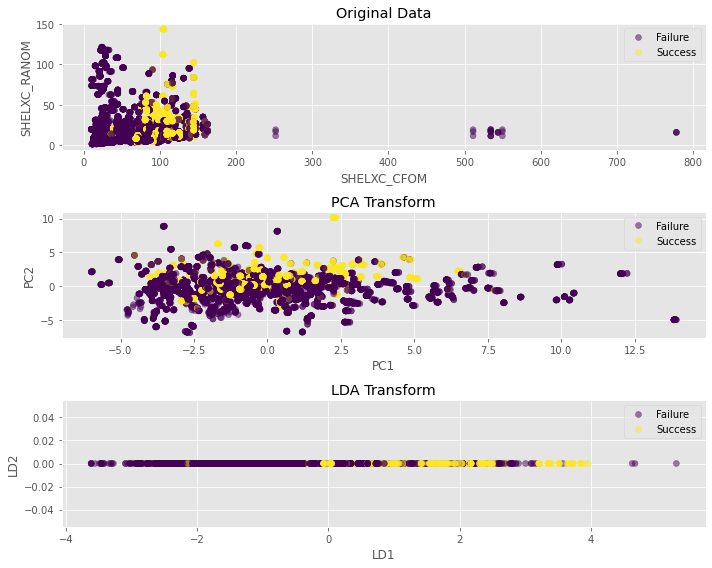

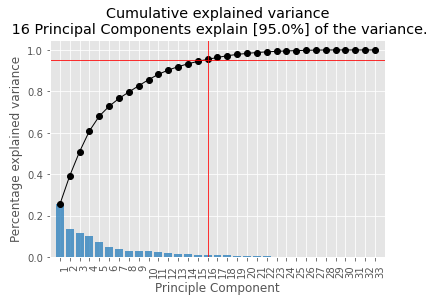

------------------------------
1 > 1.68-2.44 > Success Rate: 41.29%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.027411  0.445921       0.320368
SHELXC_RANOM            0.027417  0.444574       0.319427
RMEAS_DIFF_I            0.029784  0.021879       0.024250
RMEAS_I                 0.029428  0.019001       0.022129
RMERGE_DIFF_I           0.034453  0.014188       0.020267
RMERGE_I                0.034235  0.013012       0.019379
RPIM_DIFF_I             0.031656  0.006449       0.014011
DIFF_F                  0.031121  0.004855       0.012734
CC_HALF                 0.036953  0.002338       0.012722
ANOMALOUS_COMPLETENESS  0.034867  0.003166       0.012677
                                PCA       LDA  Weighted_Mean
TOTAL_OBSERVATIONS         0.030691  0.000378       0.009472
MULTIPLICITY               0.027679  0.001477       0.009338
TOTAL_UNIQUE_OBSERVATIONS  0.028994  0.000453       0.009015
ANOMALOUS_MULTIPLICI

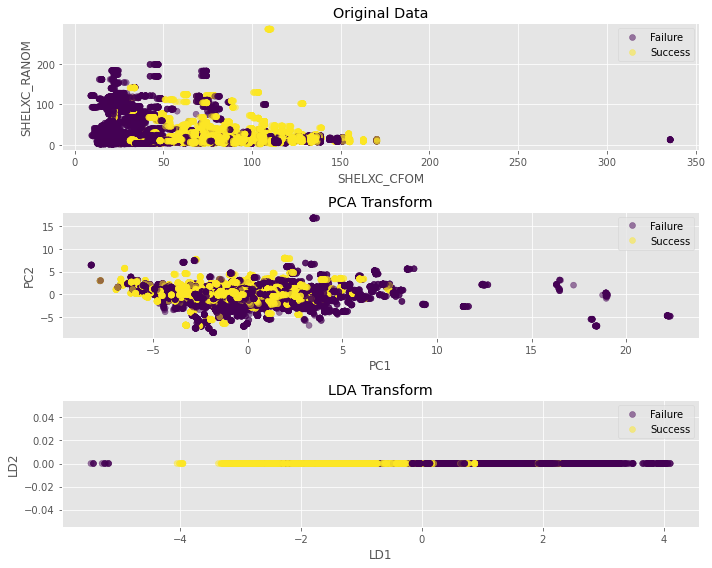

------------------------------
2 > 2.45-3.21 > Success Rate: 40.33%
Weights: PCA-30.0%, LDA-70.0%
                                PCA       LDA  Weighted_Mean
RMEAS_DIFF_I               0.030165  0.141475       0.108082
SHELXC_RANOM               0.027310  0.116182       0.089521
SHELXC_RPIM                0.027303  0.106093       0.082456
SHELXC_CFOM                0.030635  0.097478       0.077425
RMERGE_DIFF_I              0.033372  0.074444       0.062123
RPIM_DIFF_I                0.029702  0.058425       0.049808
I_SIGMA                    0.032417  0.038785       0.036874
TOTAL_UNIQUE_OBSERVATIONS  0.031307  0.039231       0.036854
NUMBER_SITES               0.030481  0.035501       0.033995
HIGH_RES_LIMIT             0.027470  0.035269       0.032929
                          PCA       LDA  Weighted_Mean
RMEAS_I              0.029841  0.007658       0.014313
SOLVENT_CONTENT      0.019584  0.011836       0.014160
SHELXC_RESOLUTION    0.035449  0.001680       0.011811
SHELXC_N_DA

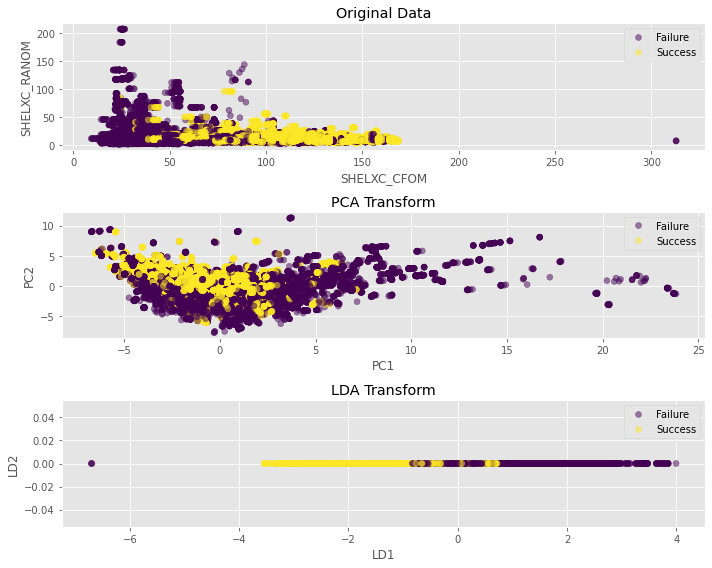

------------------------------
3 > 3.23-3.98 > Success Rate: 3.6%
Weights: PCA-30.0%, LDA-70.0%
                                PCA       LDA  Weighted_Mean
SHELXC_RPIM                0.030820  0.455335       0.327980
SHELXC_RANOM               0.030817  0.454196       0.327182
RMERGE_I                   0.030685  0.017804       0.021669
RMEAS_I                    0.028558  0.017529       0.020838
TOTAL_UNIQUE_OBSERVATIONS  0.030531  0.008158       0.014870
RPIM_DIFF_I                0.036792  0.003892       0.013762
TOT_MOLWEIGHT              0.029120  0.006488       0.013278
SHELXC_CFOM                0.029847  0.005715       0.012955
RMERGE_DIFF_I              0.034777  0.002901       0.012464
SHELXC_SIGNAL              0.031893  0.004029       0.012388
                             PCA       LDA  Weighted_Mean
ANOMALOUS_CORRELATION   0.030057  0.000560       0.009409
SHELXC_COMPLETENESS     0.029576  0.000240       0.009041
MULTIPLICITY            0.027615  0.000937       0.008941
S

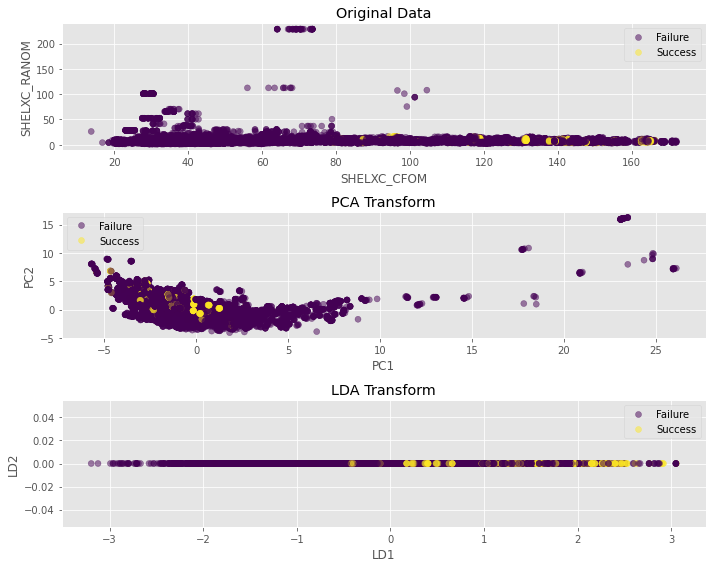

------------------------------
4 > 4.0-4.01 > Success Rate: 0.1%
Weights: PCA-30.0%, LDA-70.0%
                                PCA       LDA  Weighted_Mean
SHELXC_RANOM               0.027963  0.394257       0.284369
SHELXC_RPIM                0.027963  0.394151       0.284295
ANOMALOUS_MULTIPLICITY     0.030339  0.029043       0.029432
MULTIPLICITY               0.028836  0.029397       0.029229
RMERGE_DIFF_I              0.036103  0.023351       0.027177
RMEAS_DIFF_I               0.032361  0.024540       0.026886
RMEAS_I                    0.028296  0.017862       0.020992
RPIM_I                     0.033961  0.010384       0.017457
TOTAL_UNIQUE_OBSERVATIONS  0.031185  0.010206       0.016500
DIFF_I                     0.025774  0.011609       0.015859
                             PCA       LDA  Weighted_Mean
SHELXC_CFOM             0.031968  0.001481       0.010627
ANOMALOUS_COMPLETENESS  0.031796  0.001406       0.010523
SOLVENT_CONTENT         0.022415  0.003592       0.009239
DI

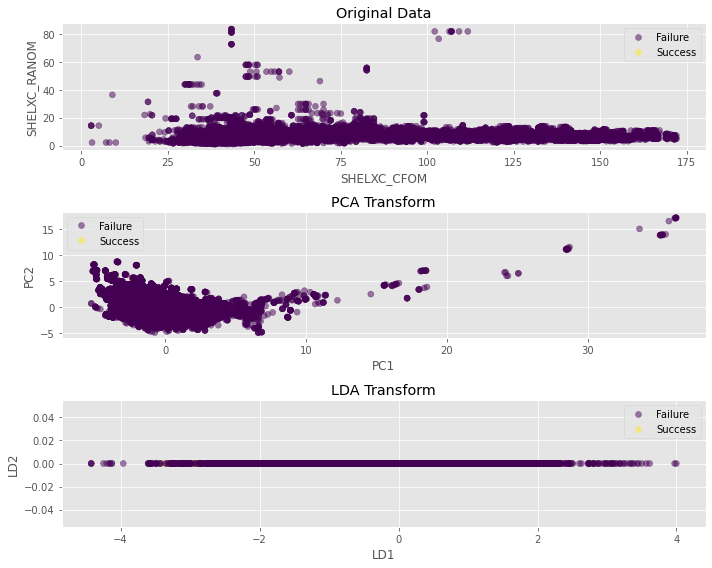

------------------------------
5 > 5.0-5.02 > Success Rate: 0.26%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.028660  0.420179       0.302723
SHELXC_RANOM            0.028675  0.420064       0.302647
RMEAS_DIFF_I            0.029676  0.037897       0.035430
RMERGE_DIFF_I           0.034245  0.023212       0.026522
ANOMALOUS_MULTIPLICITY  0.030619  0.017360       0.021338
RPIM_DIFF_I             0.037026  0.014416       0.021199
MULTIPLICITY            0.029182  0.017756       0.021184
ANOMALOUS_SLOPE         0.027780  0.009543       0.015014
RMERGE_I                0.032840  0.005226       0.013510
SHELXC_I_SIGMA          0.035715  0.003559       0.013206
                             PCA       LDA  Weighted_Mean
ANOMALOUS_COMPLETENESS  0.031417  0.000146       0.009528
SHELXC_CFOM             0.030165  0.000327       0.009279
DIFF_F                  0.029087  0.000261       0.008909
SHELXC_MULTIPLICITY     0.028075  

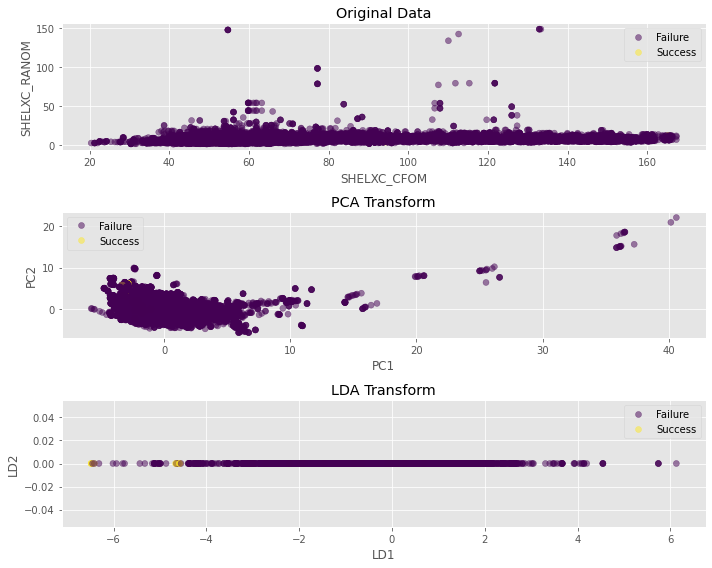

------------------------------
6 > 6.0-6.03 > Success Rate: 0.54%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.029335  0.389564       0.281495
SHELXC_RANOM            0.029349  0.389396       0.281382
RMEAS_I                 0.029557  0.071543       0.058947
RMERGE_I                0.033001  0.045791       0.041954
RPIM_I                  0.034843  0.022975       0.026535
RPIM_DIFF_I             0.034906  0.013229       0.019732
RMEAS_DIFF_I            0.030103  0.013057       0.018171
ANOMALOUS_MULTIPLICITY  0.031386  0.011655       0.017574
MULTIPLICITY            0.029866  0.011771       0.017199
ANOMALOUS_SLOPE         0.030468  0.007637       0.014486
                          PCA       LDA  Weighted_Mean
COMPLETENESS         0.031447  0.000340       0.009672
SHELXC_CFOM          0.027638  0.001181       0.009118
TOTAL_OBSERVATIONS   0.028769  0.000546       0.009013
SHELXC_COMPLETENESS  0.029493  0.000099       

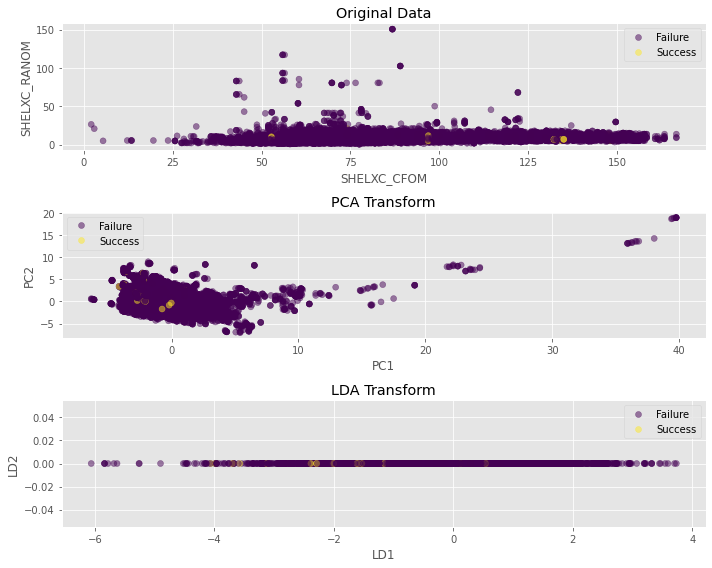

------------------------------
7 > 7.0-7.06 > Success Rate: 0.38%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.025959  0.380950       0.274453
SHELXC_RANOM            0.025956  0.380412       0.274075
RMEAS_DIFF_I            0.028718  0.058107       0.049290
RMERGE_DIFF_I           0.033358  0.041399       0.038987
RPIM_DIFF_I             0.036208  0.019890       0.024785
ANOMALOUS_MULTIPLICITY  0.029841  0.014895       0.019379
RMERGE_I                0.034835  0.011422       0.018446
RMEAS_I                 0.029549  0.012423       0.017561
MULTIPLICITY            0.027908  0.011885       0.016692
DIFF_F                  0.030580  0.009145       0.015576
                             PCA       LDA  Weighted_Mean
SHELXC_MULTIPLICITY     0.027805  0.003024       0.010458
ANOMALOUS_COMPLETENESS  0.030509  0.001572       0.010253
ANOMALOUS_SLOPE         0.032301  0.000338       0.009927
NUMBER_SITES            0.029905  

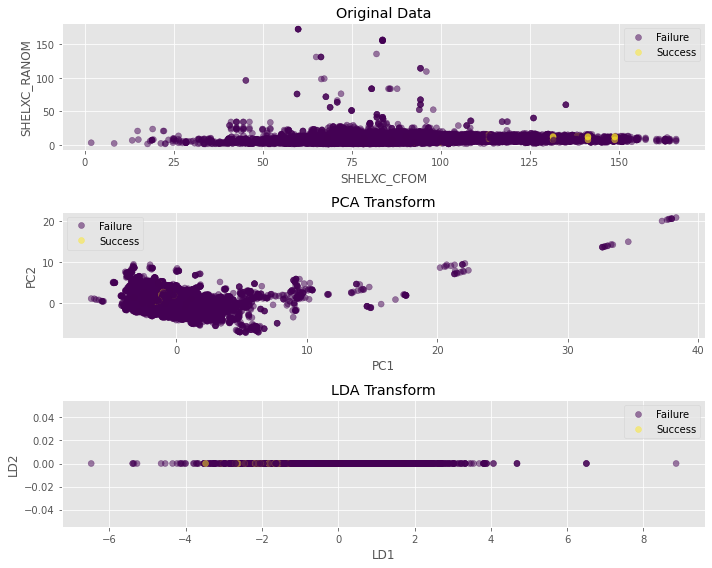

------------------------------------------------------------
3Dii
------------------------------
0 > 0.91-1.67 > Success Rate: 41.91%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.025128  0.475843       0.340629
SHELXC_RANOM            0.025123  0.475436       0.340342
RMERGE_I                0.033055  0.004259       0.012898
RMEAS_I                 0.029733  0.005607       0.012845
TOT_MOLWEIGHT           0.030846  0.004094       0.012120
COMPLETENESS            0.035665  0.001559       0.011791
ANOMALOUS_COMPLETENESS  0.036587  0.001037       0.011702
DIFF_F                  0.032398  0.002733       0.011632
RPIM_DIFF_I             0.032971  0.002469       0.011619
NUMBER_SITES            0.033846  0.002037       0.011580
                                PCA       LDA  Weighted_Mean
ANOMALOUS_CORRELATION      0.032565  0.000242       0.009939
SHELXC_CFOM                0.027578  0.002314       0.009893
SHELXC_I_SIGMA 

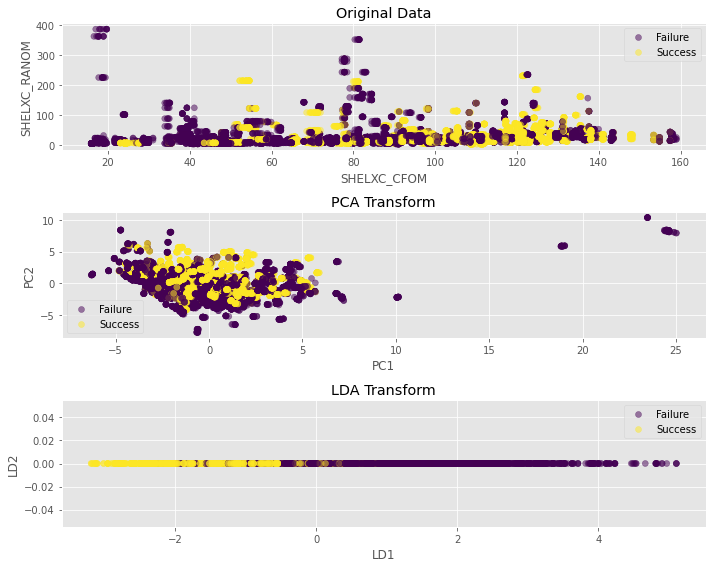

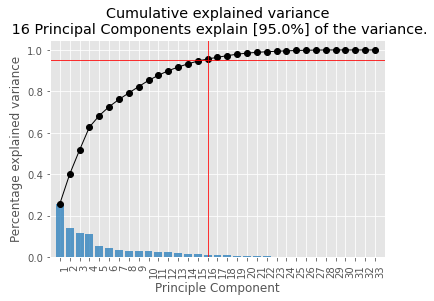

------------------------------
1 > 1.68-2.44 > Success Rate: 58.54%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RANOM            0.025765  0.482215       0.345280
SHELXC_RPIM             0.025762  0.482209       0.345275
RMEAS_DIFF_I            0.029734  0.009405       0.015503
RMERGE_DIFF_I           0.030454  0.006982       0.014024
ANOMALOUS_COMPLETENESS  0.036993  0.000888       0.011719
DIFF_F                  0.030823  0.003146       0.011449
CC_HALF                 0.035979  0.000899       0.011423
COMPLETENESS            0.036726  0.000468       0.011345
TOT_MOLWEIGHT           0.033038  0.001234       0.010775
SHELXC_RESOLUTION       0.034806  0.000194       0.010578
                                PCA       LDA  Weighted_Mean
MULTIPLICITY               0.029001  0.000830       0.009281
SHELXC_MULTIPLICITY        0.030480  0.000049       0.009178
SHELXC_COMPLETENESS        0.030364  0.000084       0.009168
RMEAS_I             

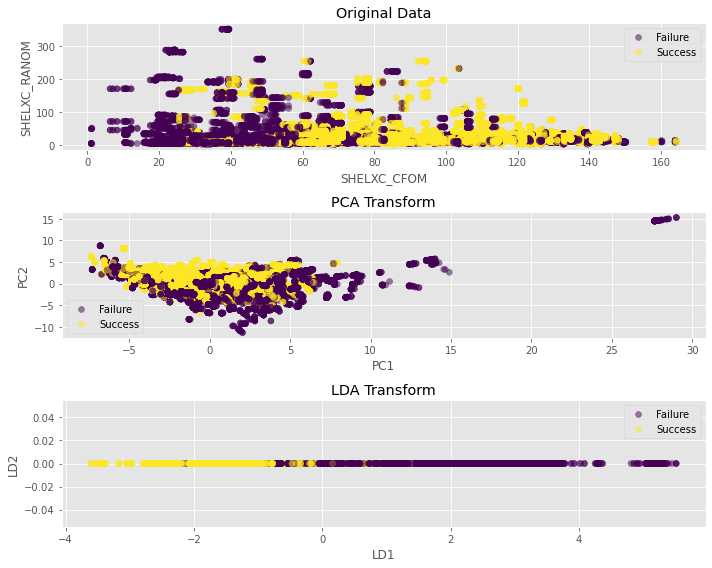

------------------------------
2 > 2.45-3.07 > Success Rate: 56.91%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.026095  0.424704       0.305121
SHELXC_RANOM            0.026104  0.424008       0.304637
RMEAS_I                 0.028829  0.022698       0.024537
RMERGE_I                0.031225  0.021653       0.024525
ANOMALOUS_MULTIPLICITY  0.027497  0.011824       0.016526
MULTIPLICITY            0.027437  0.011560       0.016323
RMEAS_DIFF_I            0.029666  0.010512       0.016258
RPIM_DIFF_I             0.029404  0.008844       0.015012
DIFF_I                  0.036009  0.005681       0.014780
RPIM_I                  0.031099  0.007722       0.014735
                                PCA       LDA  Weighted_Mean
HIGH_RES_LIMIT             0.029644  0.002492       0.010638
TOTAL_OBSERVATIONS         0.030008  0.002198       0.010541
SHELXC_I_SIGMA             0.034794  0.000072       0.010488
SHELXC_N_DATA       

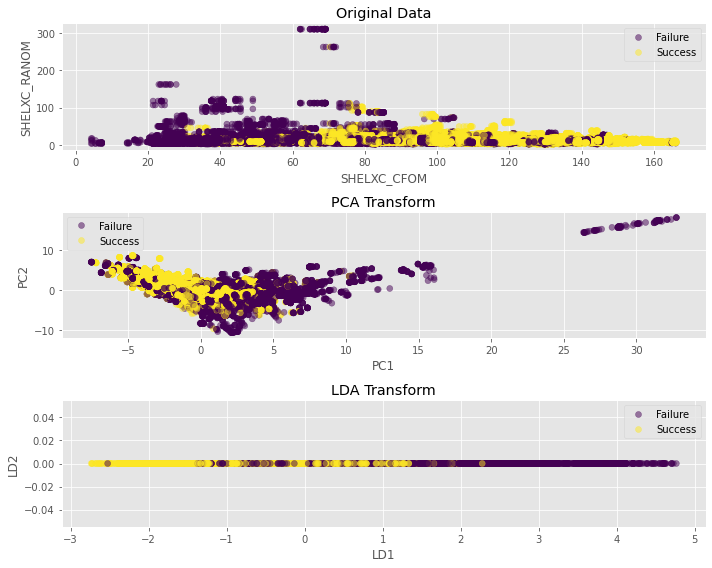

------------------------------
3 > 3.41-3.86 > Success Rate: 6.76%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.032047  0.435049       0.314148
SHELXC_RANOM            0.032054  0.434876       0.314029
RMERGE_DIFF_I           0.033425  0.023978       0.026812
RMEAS_DIFF_I            0.029821  0.022352       0.024593
ANOMALOUS_MULTIPLICITY  0.032349  0.009520       0.016369
MULTIPLICITY            0.031273  0.007642       0.014732
DIFF_I                  0.032205  0.006454       0.014180
RPIM_I                  0.033853  0.005477       0.013990
ANOMALOUS_SLOPE         0.026574  0.007560       0.013264
RMEAS_I                 0.027102  0.006959       0.013002
                             PCA       LDA  Weighted_Mean
COMPLETENESS            0.033030  0.000110       0.009986
HIGH_RES_LIMIT          0.032803  0.000185       0.009970
TOTAL_OBSERVATIONS      0.027910  0.002158       0.009883
ANOMALOUS_COMPLETENESS  0.030027 

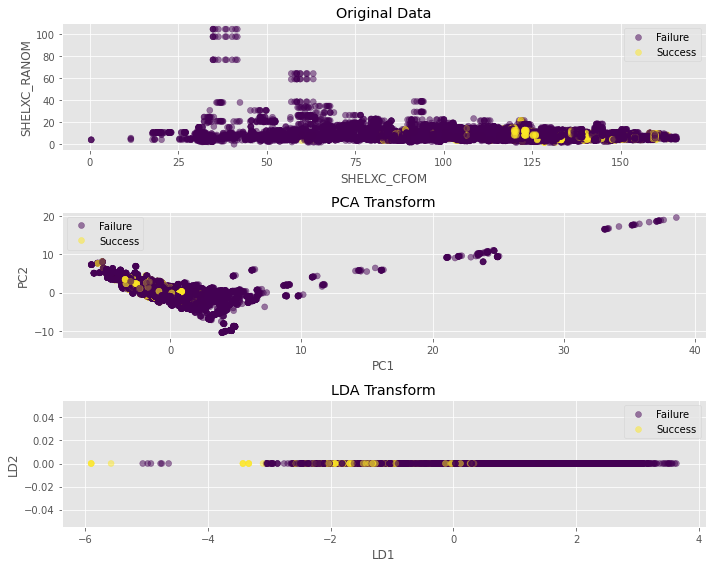

------------------------------
4 > 4.0-4.01 > Success Rate: 0.66%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.030595  0.315925       0.230326
SHELXC_RANOM            0.030612  0.313649       0.228738
RMEAS_I                 0.026245  0.102473       0.079604
RMERGE_I                0.032725  0.072903       0.060849
RPIM_I                  0.031088  0.033959       0.033098
ANOMALOUS_MULTIPLICITY  0.033935  0.027419       0.029374
RMEAS_DIFF_I            0.030230  0.028783       0.029217
MULTIPLICITY            0.032215  0.023009       0.025771
RPIM_DIFF_I             0.035468  0.014550       0.020826
RMERGE_DIFF_I           0.034121  0.012506       0.018991
                          PCA       LDA  Weighted_Mean
CC_HALF              0.030778  0.001580       0.010340
TOT_MOLWEIGHT        0.029744  0.001957       0.010293
SHELXC_COMPLETENESS  0.032910  0.000155       0.009982
SHELXC_N_DATA        0.027519  0.001723       

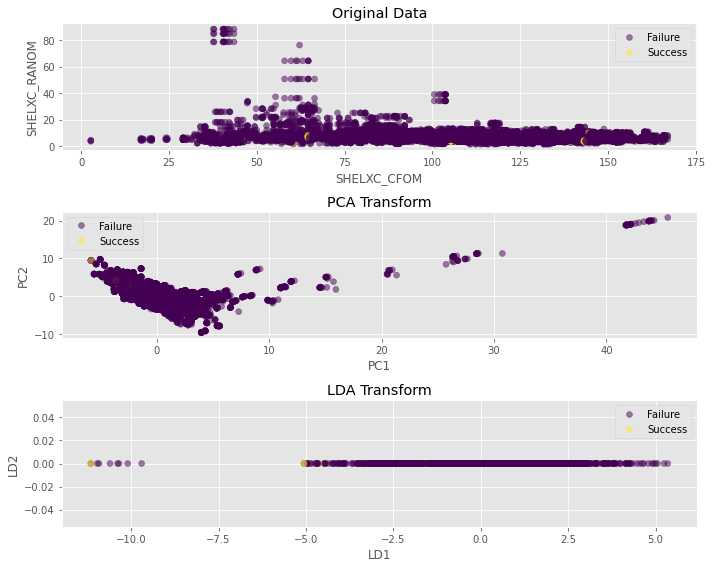

------------------------------
5 > 5.0-5.01 > Success Rate: 0.39%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RANOM            0.029131  0.417075       0.300692
SHELXC_RPIM             0.029155  0.415598       0.299665
RMEAS_DIFF_I            0.030457  0.035511       0.033995
RMERGE_DIFF_I           0.035595  0.024828       0.028058
RMEAS_I                 0.028276  0.021639       0.023630
RMERGE_I                0.034326  0.014210       0.020245
RPIM_DIFF_I             0.036497  0.012574       0.019751
RPIM_I                  0.033008  0.007856       0.015401
I_SIGMA                 0.033274  0.006807       0.014747
ANOMALOUS_MULTIPLICITY  0.033887  0.005350       0.013911
                            PCA       LDA  Weighted_Mean
SHELXC_COMPLETENESS    0.030099  0.000698       0.009518
NUMBER_SITES           0.028510  0.000886       0.009173
ANOMALOUS_CORRELATION  0.029798  0.000248       0.009113
HIGH_RES_LIMIT         0.024176  0.002

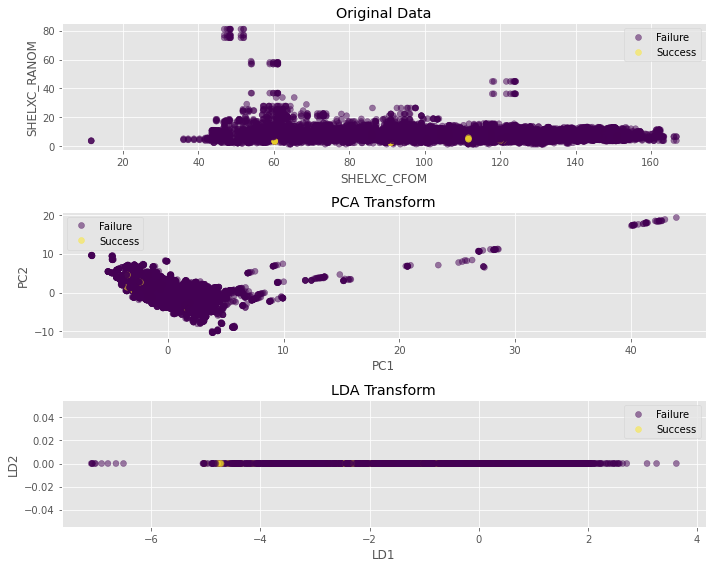

------------------------------
6 > 6.0-6.04 > Success Rate: 0.98%
Weights: PCA-30.0%, LDA-70.0%
                                PCA       LDA  Weighted_Mean
SHELXC_RANOM               0.030723  0.437720       0.315621
SHELXC_RPIM                0.030729  0.436972       0.315099
RMEAS_DIFF_I               0.029465  0.029025       0.029157
RMERGE_DIFF_I              0.033595  0.014905       0.020512
RPIM_DIFF_I                0.035596  0.013343       0.020019
ANOMALOUS_MULTIPLICITY     0.033981  0.012602       0.019015
MULTIPLICITY               0.033544  0.009830       0.016944
RMERGE_I                   0.032531  0.005182       0.013387
DIFF_I                     0.031468  0.004719       0.012744
TOTAL_UNIQUE_OBSERVATIONS  0.029996  0.004888       0.012420
                            PCA       LDA  Weighted_Mean
SHELXC_CFOM            0.029812  0.000731       0.009455
CC_HALF                0.030535  0.000414       0.009450
ANOMALOUS_CORRELATION  0.031264  0.000097       0.009447
NUMBE

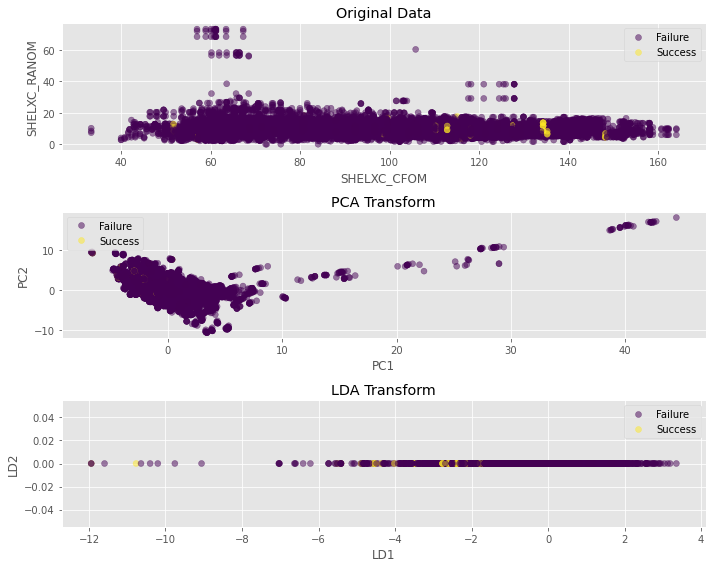

------------------------------
7 > 7.0-7.06 > Success Rate: 0.71%
Weights: PCA-30.0%, LDA-70.0%
                             PCA       LDA  Weighted_Mean
SHELXC_RPIM             0.029772  0.353805       0.256595
SHELXC_RANOM            0.029765  0.352206       0.255474
RMEAS_I                 0.028851  0.081231       0.065517
RMERGE_I                0.032646  0.055450       0.048609
RPIM_I                  0.033796  0.025935       0.028293
I_SIGMA                 0.036525  0.015951       0.022123
DIFF_I                  0.033956  0.016269       0.021575
SHELXC_I_SIGMA          0.036866  0.009524       0.017727
RPIM_DIFF_I             0.034413  0.009492       0.016968
ANOMALOUS_MULTIPLICITY  0.034412  0.008407       0.016209
                            PCA       LDA  Weighted_Mean
CC_HALF                0.030385  0.001284       0.010015
LOW_RES_LIMIT          0.025724  0.003278       0.010012
SHELXC_CFOM            0.025823  0.003094       0.009913
DIFF_F                 0.030077  0.000

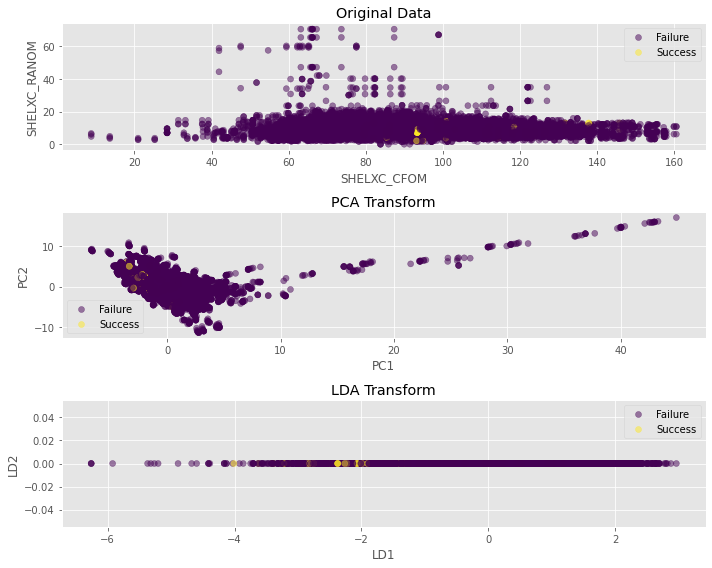

------------------------------------------------------------


In [6]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from pca import pca
%matplotlib inline
plt.rcParams['figure.dpi'] = 72


for db_kind, db in data.items():
    print(db_kind.title())
    x, y = db.unpack(drop_col=["SPACEGROUP", "DATASET_id"])

    # group by high resolution limit
    n_groups = 8
    groups = GroupedHighResolution(x, y)
    groups.group(n_groups=n_groups)

    for i, datum in groups:
        print("-" * 30)
        # prepare data
        X, y = datum.unpack()
        agg = X["HIGH_RES_LIMIT"].agg(["min", "max"])
        print(f"{i} > {agg['min']}-{agg['max']} > Success Rate: {round(y.sum() / y.size * 100, 2)}%")
        fig, (ax_up, ax_mid, ax_down) = plt.subplots(3, 1, figsize=(10,8))

        # show original data
        sct_up = ax_up.scatter(X["SHELXC_CFOM"], X["SHELXC_RANOM"], c=y, alpha=.5)
        ax_up.set_xlabel("SHELXC_CFOM")
        ax_up.set_ylabel("SHELXC_RANOM")
        ax_up.set_title("Original Data")
        handles, labels = sct_up.legend_elements()
        labels = ["Failure", "Success"]
        ax_up.legend(handles=handles, labels=labels)

        # fit PCA to data
        pca_model = pca(n_components=0.95, normalize=True)
        pca_new = pca_model.fit_transform(X, verbose=2)
        # show PC1 vs PC2
        ax_mid.scatter(pca_new["PC"].iloc[:, 0], pca_new["PC"].iloc[:, 1], c=y, alpha=.5)
        ax_mid.set_xlabel("PC1")
        ax_mid.set_ylabel("PC2")
        ax_mid.set_title("PCA Transform")
        ax_mid.legend(handles=handles, labels=labels)

        # fit LDA to data
        lda = make_pipeline(StandardScaler(), LDA())
        lda_new = lda.fit_transform(X, y)
        # show LD1 with dummy y axis
        ax_down.scatter(lda_new, np.zeros_like(lda_new), c=y, alpha=.5)
        ax_down.set_xlabel("LD1")
        ax_down.set_ylabel("LD2")
        ax_down.set_title("LDA Transform")
        ax_down.legend(handles=handles, labels=labels)

        # get feature importances from loadings
        pca_loadings = pca_new["loadings"].abs().sum(axis=0)
        lda_loadings = pd.Series(abs(lda[1].coef_[0]), index=X.columns)
        # normalize loadings
        pca_loadings /= pca_loadings.sum()
        lda_loadings /= lda_loadings.sum()

        # total feature importances with custom weights
        topfeat = pd.DataFrame({"PCA": pca_loadings, "LDA": lda_loadings})
        weights = [0.3, 0.7]  # 30% PCA, 70% LDA, since LDA gives better separation
        topfeat["Weighted_Mean"] = np.average(topfeat, axis=1, weights=weights)
        topfeat_pretty = topfeat.sort_values(by="Weighted_Mean", ascending=False)

        # show results
        print(f"Weights: PCA-{weights[0]*100}%, LDA-{weights[1]*100}%")
        print(topfeat_pretty.head(10))
        print(topfeat_pretty.tail(10))
        plt.tight_layout()
        plt.show()
        if i==0:
            fig, ax = pca_model.plot(figsize=(6,4), visible=False)
            fig.set_visible(True)
            plt.show()
    
    print("-"*60)

- **PCA and (especially) LDA work very well** and are able to mostly differentiate success/failure, but only in the "optimal range" (up to group 3, ~3.5 angstrom)
- For lower resolutions, failure dominates so largely that it is practically impossible to identify success
- LDA consistently values **SHELXC RANOM/RPIM** over all other features, closely followed by **RMERGE/RMEAS (DIFF) I**, while PCA is largely spread out on every features
- Both LDA and PCA give the least value to **F''**, **low/high resolution limit** and **solvent content**

Now use a few models to get feature importance, using coefficients as importance weights.

Dials
------------------------------
0 > 0.91-1.67 > Success Rate: 22.21%
Tree Depth: 15
Forest avg depth: 18.52


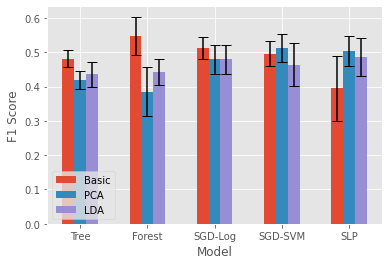

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.221667  0.099222  0.036486  0.046930  0.022002   
NUMBER_SITES               0.154837  0.076990  0.068387  0.053288  0.055537   
TOTAL_UNIQUE_OBSERVATIONS  0.015975  0.037596 -0.097591 -0.085834 -0.102547   
ANOMALOUS_MULTIPLICITY     0.024105  0.013032 -0.055166 -0.090581 -0.082673   
TOTAL_OBSERVATIONS         0.054231  0.037577  0.049465  0.049819  0.041308   
I_SIGMA                    0.026803  0.033511 -0.065555 -0.046599 -0.031780   
CC_HALF                    0.005156  0.005799  0.070502  0.053073  0.077088   
RMERGE_I                   0.000000  0.018153  0.046618  0.072482  0.069030   
ANOMALOUS_COMPLETENESS     0.010212  0.039356  0.062230  0.041340  0.043421   
RMERGE_DIFF_I              0.033823  0.018341 -0.050708 -0.052356 -0.031006   

                           Weighted_Mean  
SHELXC_CFOM                     0.087047  
NUMBER_SITES                    0.082267  
T

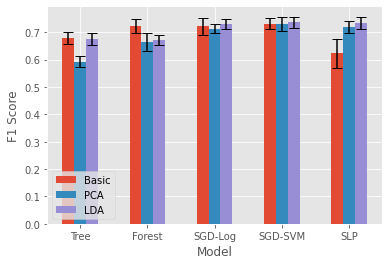

                            Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM             0.369212  0.148063  0.060809  0.066813  0.060517   
DIFF_F                  0.075970  0.032694  0.102316  0.104185  0.078912   
TOT_MOLWEIGHT           0.054553  0.040986 -0.088753 -0.082300 -0.131504   
RMEAS_DIFF_I            0.011581  0.017732  0.062034  0.075546  0.092005   
COMPLETENESS            0.018006  0.014112 -0.074038 -0.060239 -0.091653   
ANOMALOUS_COMPLETENESS  0.016890  0.020130  0.078215  0.058737  0.068213   
CC_HALF                 0.011257  0.009797  0.063354  0.061465  0.083967   
DIFF_I                  0.016745  0.063538  0.038188  0.049613  0.027243   
NUMBER_SITES            0.037606  0.041831  0.038922  0.039037  0.030096   
ANOMALOUS_SLOPE         0.012143  0.052915 -0.037976 -0.039354 -0.029005   

                        Weighted_Mean  
SHELXC_CFOM                  0.140387  
DIFF_F                       0.078906  
TOT_MOLWEIGHT                0.078445  
RME

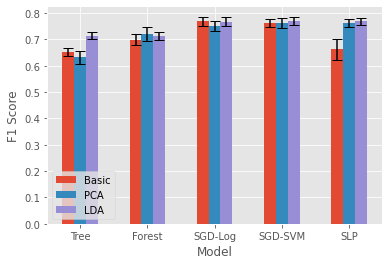

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.446601  0.177532  0.148083  0.128894  0.079881   
I_SIGMA                    0.028041  0.030456 -0.089441 -0.079209 -0.095484   
CC_HALF                    0.007832  0.008842  0.090292  0.089774  0.075001   
NUMBER_SITES               0.034460  0.021123  0.079976  0.073130  0.020386   
TOTAL_UNIQUE_OBSERVATIONS  0.030397  0.034006 -0.074697 -0.047597 -0.036771   
HIGH_RES_LIMIT             0.047701  0.024986 -0.050409 -0.054318 -0.009808   
RMEAS_DIFF_I               0.022093  0.020682 -0.025400 -0.053066 -0.059371   
RPIM_DIFF_I                0.012540  0.017682  0.040701  0.052927  0.042619   
SOLVENT_CONTENT            0.059924  0.028612  0.016969  0.030193  0.036247   
DIFF_I                     0.034667  0.060510  0.024748  0.027788  0.013606   

                           Weighted_Mean  
SHELXC_CFOM                     0.192034  
I_SIGMA                         0.065431  
C

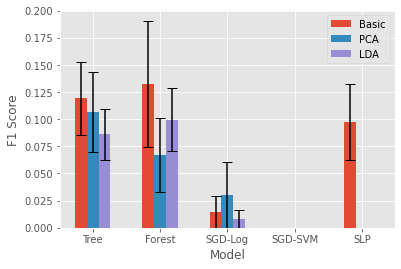

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.305416  0.125214  0.072997  0.038533  0.039188   
LOW_RES_LIMIT              0.121574  0.066978  0.001677  0.017887 -0.001277   
TOTAL_UNIQUE_OBSERVATIONS  0.076467  0.079097 -0.026185  0.009801  0.034488   
TOTAL_OBSERVATIONS         0.059826  0.069341 -0.022668 -0.009723 -0.036611   
CC_HALF                    0.002614  0.009788  0.142130  0.274192  0.163548   
SOLVENT_CONTENT            0.081772  0.054040  0.030455  0.004484  0.008329   
TOT_MOLWEIGHT              0.047643  0.029495 -0.019716 -0.041382 -0.080687   
COMPLETENESS               0.060693  0.017921 -0.079651 -0.045172 -0.045491   
ANOMALOUS_COMPLETENESS     0.012571  0.024074  0.127301  0.104464  0.084581   
ANOMALOUS_CORRELATION      0.023779  0.058097  0.031388  0.000916  0.013362   

                           Weighted_Mean  
SHELXC_CFOM                     0.159124  
LOW_RES_LIMIT                   0.064651  
T

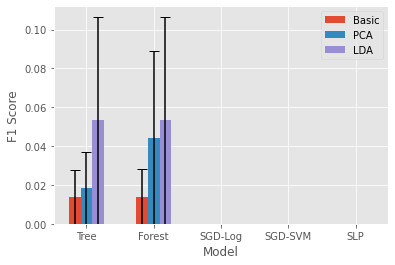

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
COMPLETENESS               0.251031  0.065479 -0.015262 -0.016454 -0.045463   
I_SIGMA                    0.149727  0.085317  0.059895  0.059785 -0.003575   
SHELXC_CFOM                0.112162  0.107804  0.044765  0.045315  0.033335   
ANOMALOUS_SLOPE            0.114441  0.054393  0.026514  0.025411 -0.014578   
TOTAL_OBSERVATIONS         0.092442  0.067007 -0.029258 -0.030521 -0.108544   
ANOMALOUS_COMPLETENESS     0.110455  0.045925 -0.013462 -0.014987  0.007959   
TOTAL_UNIQUE_OBSERVATIONS  0.040047  0.094595 -0.048554 -0.048902 -0.003801   
RMEAS_I                    0.056653  0.017849 -0.028263 -0.027725  0.005717   
LOW_RES_LIMIT              0.000000  0.073505  0.009414  0.011077 -0.010586   
RPIM_I                     0.060087  0.010162 -0.033176 -0.032997 -0.013671   

                           Weighted_Mean  
COMPLETENESS                    0.157448  
I_SIGMA                         0.117242  
S

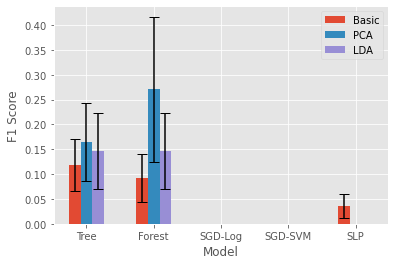

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
LOW_RES_LIMIT              0.342876  0.088875  0.006522  0.007725  0.015530   
DIFF_I                     0.146777  0.071402  0.017241  0.017727 -0.044636   
TOTAL_UNIQUE_OBSERVATIONS  0.120877  0.092045 -0.074757 -0.072121 -0.018482   
SHELXC_CFOM                0.096929  0.085208  0.023003  0.022391 -0.012514   
TOTAL_OBSERVATIONS         0.072769  0.088445 -0.040152 -0.037390 -0.049629   
TOT_MOLWEIGHT              0.087477  0.020381 -0.071148 -0.068884  0.003670   
ANOMALOUS_SLOPE            0.026589  0.059769  0.035233  0.038978  0.089981   
SHELXC_I_SIGMA             0.043662  0.012931 -0.022564 -0.012714 -0.129563   
ANOMALOUS_COMPLETENESS     0.031607  0.019713  0.049889  0.047738  0.056599   
ANOMALOUS_CORRELATION      0.000000  0.065540  0.057568  0.059871  0.034940   

                           Weighted_Mean  
LOW_RES_LIMIT                   0.199545  
DIFF_I                          0.103508  
T

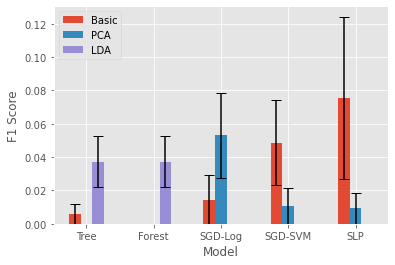

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
TOT_MOLWEIGHT              0.024680  0.019619 -0.090352 -0.092396 -0.078344   
SHELXC_RESOLUTION          0.000000  0.006050 -0.098363 -0.117024 -0.053401   
CC_HALF                    0.000000  0.009106  0.038957  0.046144  0.102715   
NUMBER_SITES               0.000000  0.009574 -0.100695 -0.106103 -0.034714   
ANOMALOUS_COMPLETENESS     0.016479  0.019684  0.086115  0.093780  0.043669   
TOTAL_UNIQUE_OBSERVATIONS  0.125614  0.083727 -0.063596 -0.054265  0.044415   
DIFF_I                     0.062281  0.057412 -0.023918 -0.022045 -0.064913   
ANOMALOUS_SLOPE            0.018623  0.050141  0.032644  0.030804  0.060970   
COMPLETENESS               0.017255  0.025176  0.077143  0.083787 -0.012497   
SHELXC_I_SIGMA             0.033990  0.018359 -0.014245 -0.016094 -0.062332   

                           Weighted_Mean  
TOT_MOLWEIGHT                   0.082038  
SHELXC_RESOLUTION               0.077057  
C

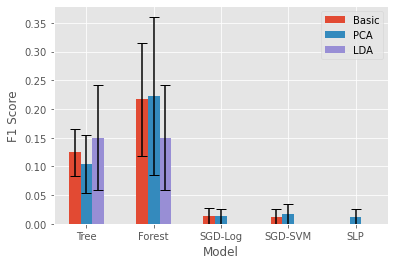

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.351430  0.133854  0.058458  0.051014  0.031344   
I_SIGMA                    0.181731  0.055037 -0.019109 -0.020605 -0.006841   
LOW_RES_LIMIT              0.081293  0.097886  0.030661  0.026493 -0.003014   
TOTAL_UNIQUE_OBSERVATIONS  0.076468  0.077898 -0.045751 -0.043627  0.036460   
TOTAL_OBSERVATIONS         0.038461  0.069049 -0.013759 -0.010011 -0.021120   
ANOMALOUS_CORRELATION      0.027768  0.056300  0.070509  0.070617  0.019302   
SOLVENT_CONTENT            0.076806  0.027647  0.007006  0.006781 -0.004167   
MULTIPLICITY               0.021778  0.043136  0.006463  0.004691 -0.052571   
RMERGE_DIFF_I              0.068376  0.014664 -0.009881 -0.009313  0.035695   
DIFF_I                     0.013791  0.040095 -0.010525 -0.011399 -0.044185   

                           Weighted_Mean  
SHELXC_CFOM                     0.202271  
I_SIGMA                         0.095636  
L

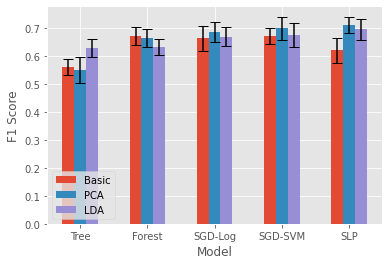

                            Tree    Forest   SGD-Log   SGD-SVM       SLP  \
TOT_MOLWEIGHT           0.045861  0.044855 -0.114700 -0.120761 -0.108472   
SHELXC_CFOM             0.187311  0.125597  0.042393  0.036094  0.030076   
NUMBER_SITES            0.077723  0.054558  0.062202  0.061494  0.043296   
CC_HALF                 0.004059  0.014388  0.083657  0.074979  0.086753   
MULTIPLICITY            0.005189  0.043100  0.056554  0.072679  0.059905   
ANOMALOUS_MULTIPLICITY  0.000775  0.032444 -0.057838 -0.078570 -0.062477   
RMERGE_I                0.056231  0.025146  0.036248  0.030652  0.065764   
RPIM_DIFF_I             0.016924  0.025125  0.060843  0.044954  0.056596   
TOTAL_OBSERVATIONS      0.059557  0.041459  0.032692  0.026417  0.025935   
DIFF_F                  0.014500  0.020635  0.051104  0.048776  0.042592   

                        Weighted_Mean  
TOT_MOLWEIGHT                0.087903  
SHELXC_CFOM                  0.081752  
NUMBER_SITES                 0.059495  
CC_

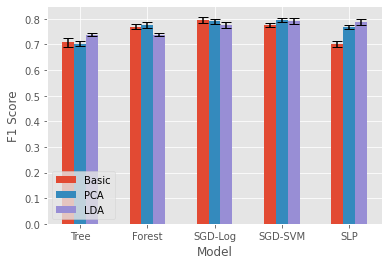

                   Tree    Forest   SGD-Log   SGD-SVM       SLP  Weighted_Mean
SHELXC_CFOM    0.248064  0.134831  0.059657  0.066807  0.053653       0.111005
DIFF_F         0.020295  0.027446  0.148950  0.154122  0.112346       0.093982
TOT_MOLWEIGHT  0.082602  0.058451 -0.080982 -0.086432 -0.081906       0.077977
NUMBER_SITES   0.092182  0.063684  0.046519  0.045177  0.051745       0.059362
RMERGE_I       0.046561  0.028392 -0.063080 -0.073959 -0.071595       0.056705
RMERGE_DIFF_I  0.005138  0.022069 -0.062237 -0.058545 -0.100330       0.049591
RMEAS_DIFF_I   0.003770  0.023253  0.074097  0.061770  0.082758       0.049466
CC_HALF        0.011466  0.010739  0.064637  0.062010  0.069400       0.043902
RPIM_I         0.014355  0.020315 -0.062669 -0.077614 -0.019024       0.039793
SHELXC_N_DATA  0.018118  0.030106 -0.035500 -0.038523 -0.028156       0.030363
                         Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_COMPLETENESS  0.022778  0.023134 -0.000243  0.00922

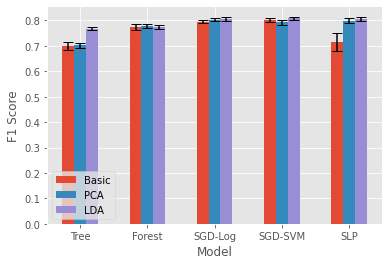

                            Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM             0.344147  0.169280  0.058643  0.060953  0.067045   
DIFF_F                  0.009590  0.017290  0.093543  0.103774  0.081666   
NUMBER_SITES            0.047856  0.034647  0.064015  0.059430  0.065124   
RMERGE_I                0.010635  0.027632 -0.057908 -0.092734 -0.073601   
ANOMALOUS_SLOPE         0.017041  0.035194  0.079623  0.062084  0.066503   
ANOMALOUS_MULTIPLICITY  0.015339  0.021360  0.071846  0.070334  0.080766   
TOT_MOLWEIGHT           0.029164  0.036400 -0.056943 -0.071058 -0.059812   
DIFF_I                  0.011571  0.029431 -0.069075 -0.057491 -0.061221   
MULTIPLICITY            0.021411  0.028330 -0.059811 -0.061545 -0.048763   
TOTAL_OBSERVATIONS      0.046384  0.041404  0.032079  0.036181  0.016657   

                        Weighted_Mean  
SHELXC_CFOM                  0.136042  
DIFF_F                       0.062371  
NUMBER_SITES                 0.054268  
RME

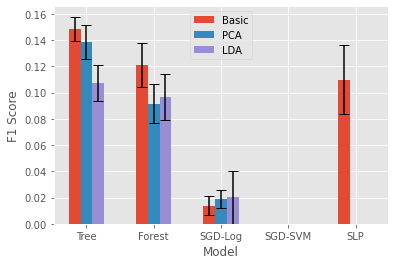

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.233272  0.116092  0.052150  0.007456  0.037532   
LOW_RES_LIMIT              0.152663  0.078814  0.010600 -0.018843  0.016616   
TOTAL_UNIQUE_OBSERVATIONS  0.100064  0.077917  0.038399  0.108020  0.076918   
TOTAL_OBSERVATIONS         0.113712  0.076364  0.030954  0.014039  0.016485   
TOT_MOLWEIGHT              0.023286  0.036306 -0.132486 -0.149316 -0.140168   
SOLVENT_CONTENT            0.097651  0.046417  0.003068 -0.006783 -0.006679   
RPIM_DIFF_I                0.026132  0.018500  0.061665  0.060108  0.053420   
DIFF_I                     0.006790  0.046785 -0.059677 -0.028935 -0.048229   
RPIM_I                     0.004463  0.014461 -0.065094 -0.083120 -0.081768   
NUMBER_SITES               0.025574  0.024221  0.080588  0.033705  0.033862   

                           Weighted_Mean  
SHELXC_CFOM                     0.136124  
LOW_RES_LIMIT                   0.086908  
T

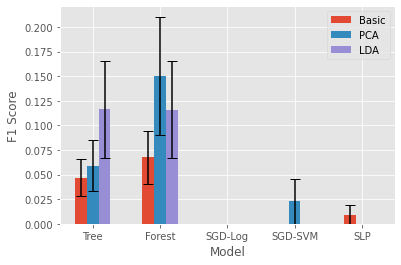

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.263360  0.122588 -0.004497 -0.006331 -0.004111   
LOW_RES_LIMIT              0.209383  0.097080  0.016512  0.004600  0.009010   
TOTAL_UNIQUE_OBSERVATIONS  0.089688  0.087522 -0.063015 -0.041285  0.007794   
TOTAL_OBSERVATIONS         0.053892  0.084341  0.054066  0.027361  0.014485   
COMPLETENESS               0.062644  0.030974  0.031491  0.003516  0.049726   
TOT_MOLWEIGHT              0.050391  0.026569 -0.107168 -0.139348 -0.097276   
DIFF_I                     0.030181  0.050995 -0.013706 -0.008587 -0.019689   
RMEAS_DIFF_I               0.067601  0.021733 -0.030393 -0.005603 -0.022232   
ANOMALOUS_CORRELATION      0.022903  0.053211  0.043374  0.008138  0.003410   
ANOMALOUS_SLOPE            0.013407  0.050007  0.011039  0.006770 -0.002523   

                           Weighted_Mean  
SHELXC_CFOM                     0.166939  
LOW_RES_LIMIT                   0.132946  
T

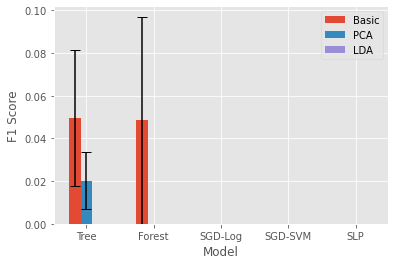

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.378770  0.147018 -0.003938 -0.004323 -0.001164   
TOTAL_UNIQUE_OBSERVATIONS  0.275372  0.079192 -0.013951 -0.000512 -0.107101   
LOW_RES_LIMIT              0.104574  0.091241  0.011618  0.015243  0.005687   
TOTAL_OBSERVATIONS         0.073905  0.075960  0.041101  0.055453  0.021363   
ANOMALOUS_CORRELATION      0.017479  0.058703  0.014235  0.013808  0.004452   
DIFF_I                     0.021429  0.045446  0.038824  0.014057  0.005211   
ANOMALOUS_SLOPE            0.000000  0.052464  0.012585 -0.005275 -0.046416   
I_SIGMA                    0.000000  0.043010  0.034804  0.049727  0.044807   
ANOMALOUS_MULTIPLICITY     0.023513  0.018869 -0.009144 -0.001881 -0.004654   
SOLVENT_CONTENT            0.012936  0.024271 -0.047007 -0.063099 -0.001630   

                           Weighted_Mean  
SHELXC_CFOM                     0.264181  
TOTAL_UNIQUE_OBSERVATIONS       0.178371  
L

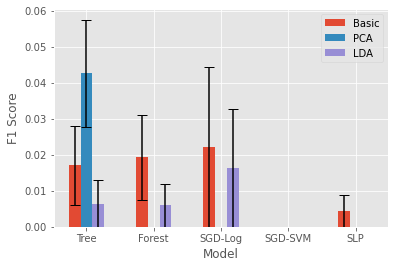

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.214657  0.111783  0.023576  0.006569  0.014414   
LOW_RES_LIMIT              0.228134  0.095956  0.023899  0.010961 -0.005561   
TOTAL_UNIQUE_OBSERVATIONS  0.083404  0.083364 -0.065033 -0.032869 -0.056588   
TOT_MOLWEIGHT              0.000000  0.024226 -0.102241 -0.179462 -0.196826   
TOTAL_OBSERVATIONS         0.055862  0.075881  0.042976  0.033750  0.048072   
MULTIPLICITY               0.105860  0.040562 -0.029734 -0.012521 -0.026699   
SOLVENT_CONTENT            0.091560  0.040572  0.023588  0.007533  0.005207   
NUMBER_SITES               0.003852  0.017829  0.100894  0.064688  0.038493   
DIFF_I                     0.010049  0.032984 -0.070131 -0.050832 -0.068566   
RPIM_I                     0.005252  0.016026 -0.069315 -0.078041 -0.062940   

                           Weighted_Mean  
SHELXC_CFOM                     0.101769  
LOW_RES_LIMIT                   0.100076  
T

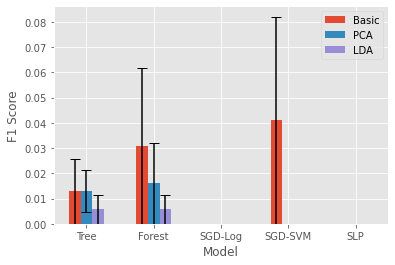

                               Tree    Forest   SGD-Log   SGD-SVM       SLP  \
SHELXC_CFOM                0.195036  0.139888  0.014631  0.008829  0.015115   
RPIM_I                     0.001176  0.015250 -0.129532 -0.154959 -0.103426   
TOT_MOLWEIGHT              0.082869  0.031833 -0.085400 -0.105245 -0.147438   
TOTAL_OBSERVATIONS         0.139868  0.077106  0.064291  0.047374  0.023433   
TOTAL_UNIQUE_OBSERVATIONS  0.099595  0.075261 -0.044381 -0.026518 -0.002021   
LOW_RES_LIMIT              0.155650  0.081412  0.012211  0.001524  0.024114   
SHELXC_N_DATA              0.138336  0.024515 -0.053254 -0.044901 -0.034165   
CC_HALF                    0.000000  0.010863  0.059543  0.082006  0.022693   
NUMBER_SITES               0.008050  0.012458  0.010687  0.070305  0.042324   
RMERGE_DIFF_I              0.002044  0.016840  0.047794  0.063312  0.032981   

                           Weighted_Mean  
SHELXC_CFOM                     0.084808  
RPIM_I                          0.080777  
T

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, Perceptron
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import sem
from grouping import GroupedHighResolution


for db_kind, db in data.items():
    print(db_kind.title())
    x, y = db.unpack(drop_col=["SPACEGROUP", "DATASET_id"])

    # group by high resolution limit
    n_groups = 8
    groups = GroupedHighResolution(x, y)
    groups.group(n_groups=n_groups)

    for i, datum in groups:
        print("-" * 30)
        # prepare data
        X, y = datum.unpack()
        agg = X["HIGH_RES_LIMIT"].agg(["min", "max"])
        print(f"{i} > {agg['min']}-{agg['max']} > Success Rate: {round(y.sum() / y.size * 100, 2)}%")
        topfeat = pd.DataFrame(index=X.columns)
        scores, errs = {}, {}

        
        # train decision tree & get features importance
        tree = DecisionTreeClassifier(max_depth=20)
        score = cross_val_score(tree, X, y, cv=5, scoring="f1", n_jobs=3)
        tree.fit(X, y)
        topfeat["Tree"] = tree.feature_importances_
        scores["Tree"] = np.mean(score)
        errs["Tree"] = sem(score)
        print("Tree Depth:", tree.get_depth())
        
        # train PCA decision tree
        tree_pca = make_pipeline(StandardScaler(), PCA(), DecisionTreeClassifier(max_depth=20))
        score = cross_val_score(tree_pca, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["Tree_PCA"] = np.mean(score)
        errs["Tree_PCA"] = sem(score)
        
        # train LDA decision tree
        tree_lda = make_pipeline(StandardScaler(), LDA(), DecisionTreeClassifier(max_depth=20))
        score = cross_val_score(tree_lda, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["Tree_LDA"] = np.mean(score)
        errs["Tree_LDA"] = sem(score)
       
        
        # train random forest & get features importance
        forest = RandomForestClassifier(max_depth=20)
        score = cross_val_score(forest, X, y, cv=5, scoring="f1", n_jobs=3)
        forest.fit(X, y)
        topfeat["Forest"] = forest.feature_importances_
        scores["Forest"] = np.mean(score)
        errs["Forest"] = sem(score)
        print("Forest avg depth:", np.mean([tree.get_depth() for tree in forest.estimators_]))
        
        # train PCA random forest
        forest_pca = make_pipeline(StandardScaler(), PCA(), RandomForestClassifier(max_depth=20))
        score = cross_val_score(forest_pca, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["Forest_PCA"] = np.mean(score)
        errs["Forest_PCA"] = sem(score)

        # train LDA random forest
        forest_lda = make_pipeline(StandardScaler(), LDA(), RandomForestClassifier(max_depth=20))
        score = cross_val_score(forest_lda, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["Forest_LDA"] = np.mean(score)
        errs["Forest_LDA"] = sem(score)
        
        
        # train logistic regression & get feature importance
        sgd_log = make_pipeline(StandardScaler(), SGDClassifier(loss="log"))
        score = cross_val_score(sgd_log, X, y, cv=5, scoring="f1", n_jobs=3)
        sgd_log.fit(X, y)
        coefs = sgd_log[1].coef_.flatten()
        topfeat["SGD-Log"] = coefs / abs(coefs).sum()
        scores["SGD-Log"] = np.mean(score)
        errs["SGD-Log"] = sem(score)

        # train PCA logistic regression
        sgd_log_pca = make_pipeline(StandardScaler(), PCA(), SGDClassifier(loss="log"))
        score = cross_val_score(sgd_log_pca, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["SGD-Log_PCA"] = np.mean(score)
        errs["SGD-Log_PCA"] = sem(score)

        # train LDA logistic regression
        sgd_log_lda = make_pipeline(StandardScaler(), LDA(), SGDClassifier(loss="log"))
        score = cross_val_score(sgd_log_lda, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["SGD-Log_LDA"] = np.mean(score)
        errs["SGD-Log_LDA"] = sem(score)
        
        
        # train SVM & get features importance
        sgd_svm = make_pipeline(StandardScaler(), SGDClassifier())
        score = cross_val_score(sgd_svm, X, y, cv=5, scoring="f1", n_jobs=3)
        sgd_svm.fit(X, y)
        coefs = sgd_svm[1].coef_.flatten()
        topfeat["SGD-SVM"] = coefs / abs(coefs).sum()
        scores["SGD-SVM"] = np.mean(score)
        errs["SGD-SVM"] = sem(score)
        
        # train PCA SVM
        sgd_svm_pca = make_pipeline(StandardScaler(), PCA(), SGDClassifier())
        score = cross_val_score(sgd_svm_pca, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["SGD-SVM_PCA"] = np.mean(score)
        errs["SGD-SVM_PCA"] = sem(score)
        
        # train LDA SVM
        sgd_svm_lda = make_pipeline(StandardScaler(), LDA(), SGDClassifier())
        score = cross_val_score(sgd_svm_lda, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["SGD-SVM_LDA"] = np.mean(score)
        errs["SGD-SVM_LDA"] = sem(score)
        
        
        # train neural network & get features importance
        slp = make_pipeline(StandardScaler(), Perceptron())
        score = cross_val_score(slp, X, y, cv=5, scoring="f1", n_jobs=3)
        slp.fit(X, y)
        coefs = slp[1].coef_.flatten()
        topfeat["SLP"] = coefs / abs(coefs).sum()
        scores["SLP"] = np.mean(score)
        errs["SLP"] = sem(score)

        # train PCA neural network
        slp_pca = make_pipeline(StandardScaler(), PCA(), SGDClassifier())
        score = cross_val_score(slp_pca, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["SLP_PCA"] = np.mean(score)
        errs["SLP_PCA"] = sem(score)

        # train LDA neural network
        slp_lda = make_pipeline(StandardScaler(), LDA(), SGDClassifier())
        score = cross_val_score(slp_lda, X, y, cv=5, scoring="f1", n_jobs=3)
        scores["SLP_LDA"] = np.mean(score)
        errs["SLP_LDA"] = sem(score)

        
        # show each model's performance
        scores_df = pd.DataFrame([scores, errs], index=["F1-Score", "Error"]).T
        n_models = scores_df.shape[0] // 3
        #print(scores_df)  # show non normalised scores
        scores_basic, err_basic = [scores_df[col][::3] for col in scores_df]
        scores_pca, err_pca = [scores_df[col][1::3] for col in scores_df]
        scores_lda, err_lda = [scores_df[col][2::3] for col in scores_df]
        hoz_main, width = np.arange(n_models)*2, .35
        fig, ax = plt.subplots()
        ax.bar(hoz_main-width, scores_basic, yerr=err_basic, capsize=5, width=width, label="Basic")
        ax.bar(hoz_main, scores_pca, yerr=err_pca, capsize=5, width=width, label="PCA")
        ax.bar(hoz_main+width, scores_lda, yerr=err_lda, capsize=5, width=width, label="LDA")
        ax.set_xticks(hoz_main); ax.set_xticklabels(scores_basic.index)
        ax.set_xlabel("Model"); ax.set_ylabel("F1 Score")
        ax.legend()
        plt.show()
        
        # use normalised f1 scores as weights
        ratios = scores_df["F1-Score"] / scores_df["Error"]
        scores_df["F1-Score"] /= scores_df["F1-Score"].sum()  # normalise f1 scores/weights
        scores_df["Error"] = scores_df["F1-Score"] / ratios  # keep original score-error ratio

        # get feature performance weighted average
        weights = scores_df.iloc[::3, 0]
        topfeat["Weighted_Mean"] = np.average(topfeat.abs().values, axis=1, weights=weights)
        topfeat_pretty = topfeat.sort_values(by="Weighted_Mean", ascending=False)
        print(topfeat_pretty.head(10))
        print(topfeat_pretty.tail(10))

    print("-" * 60)

Havew a few incomplete values for unkown reasons.

- **High resolutions**:
    - **SHELXC CFOM** dominates, also relevant **solvent content**, **number of sites** and **total molecular weight**
    - Last features usually other **SHELXC** variants, **F''** also consistently one of the worst
    - PCA/LDA with **similar** scores as non-filtered models
    - Generally, logistic regression and SVM slightly better performing than decision tree, random forest and Single-Layer Perceptron (**linear models work well**)
    - Unfiltered **SLP** performance is lower than other models, but this improves with PCA/LDA
- **Low resolution**
    - **Low resolution limit** and **total (unique) observations** relevant
    - PCA/LDA generally **improve** model performance
    - **Linear models struggle**

In [ ]:
def test_model(model, x, y, shapes=True, report=True, topfeat=True, confusion=True, tree_show_text=False, tree_show=False, figsize=(8,6)):
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
    if shapes:
        print(f"Train shape: {x_train.shape}, {y_train.shape}\n"
              f"Test shape: {x_test.shape}, {y_test.shape}\n")
    
    # fit model
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # show model and metrics
    if report:
        report = classification_report(y_test, y_pred)
        print(report)
    if topfeat:
        topfeat = pd.Series(model.feature_importances_, index=x.columns)
        topfeat_pretty = topfeat[topfeat > 0].sort_values(ascending=False)
        print(topfeat_pretty)
    if tree_show_text:
        print(export_text(model, feature_names=x.columns.tolist()))
    if tree_show:
        fig, ax = plt.subplots(figsize=figsize)
        plot_tree(model, feature_names=x.columns.tolist(), ax=ax)
        plt.show()
    
    
    return model, topfeat